<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/Chapter_4_Dynamic_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Dependencies
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy.stats import poisson

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (6, 6)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

import logging
logging.basicConfig(level=logging.DEBUG)

## Chapter 4. Dynamic Programming



### 4.1 Policy Evaluation

---

Let's reproduce Figure 4.1 from the book (page 77). We want to implement policy iteration and show that the policy converges to the optimal policy -- satisfying the Bellman optimality equations -- within a finite number of steps. ($v_{k} \to v_\pi$ as $k \to \infty$).

We follow the in-place iterative policy evaluation algorithm on page 75.


In [ ]:
def is_terminal(state: np.array) -> bool:
    '''
    Assume that upper left and bottom right are terminal states. 
    
    Args:
        state: the (x, y) coordinates of the grid world.
    Return:
        Whether the state is a terminal state (True) or not (False).
    '''
    x, y = state
    if (x == 0 and y == 0) or (x == N_ROWS-1 and y == N_COLS-1): 
        return True
    else:
        return False

In [ ]:
def step(state: np.array, action: int) -> Tuple[np.array, int]:
    '''
    Take a step in the small grid world.

    Args:
        state: the (x, y) coordinates; current position of the agent.
        action: the selected action.
    Returns:
        next_state: the position of the agent after taking the action in the state.
        reward: the reward signal optained.
    '''
    # Check if the agent is in a terminal state
    if is_terminal(state):
        return (
            state, 0
        )
    
    # Take action
    next_state = state + action

    # make sure we stay inside our grid world
    x, y = next_state
    if x < 0 or (x > N_ROWS-1) or y < 0 or (y > N_COLS-1):
        next_state = state     
    reward = -1

    #print(f'State: {state}')
    #print(f'Next state: {next_state}')

    return next_state, reward

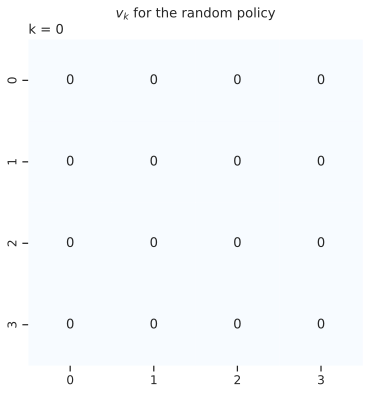

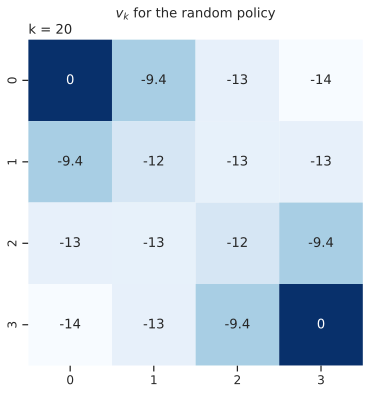

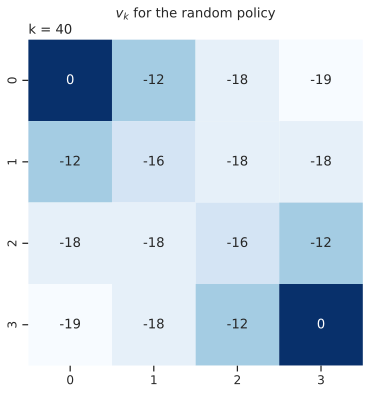

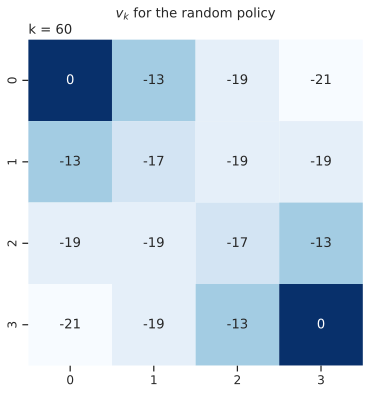

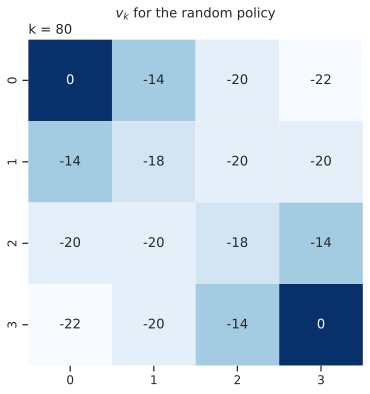

In [ ]:
# Create a simple grid world
N_ROWS = 4
N_COLS = 4

# Left, right, up, down
ACTIONS = (
    np.array([0, -1]),
    np.array([0, 1]),
    np.array([1, 0]),
    np.array([-1, 0]),
)

# Use a random policy; all actions are equally likely
PI_RAND = 1 / len(ACTIONS)

# Parameters
TERMINATE = False
THETA = 1e-2
iters = 0
GAMMA = 1

# Create grid to track the value of each state
new_state_values = np.zeros((N_ROWS, N_COLS))

while not TERMINATE:
    
    # Current is new and previous is old
    state_values = new_state_values.copy()
    old_state_values = state_values.copy()

    # Loop for each state s 
    for row_i in range(N_ROWS):
        for col_i in range(N_COLS):
            state_value = 0 
            for action in ACTIONS:
                state = np.array([row_i, col_i])

                next_state, reward = step(state, action)

                # Add reward to state value
                state_value += PI_RAND * (reward + GAMMA * state_values[next_state[0], next_state[1]])

            # Update state value after we've gone through each action
            new_state_values[row_i, col_i] = state_value

    # Show approximation of the state-value function
    if iters % 20 == 0:
        sns.heatmap(state_values, annot=True, cbar=False, cmap='Blues')
        plt.title(f'k = {iters}', loc='left')
        plt.title(r'$v_k$ for the random policy', y=1.05)
        plt.show();
        print('')

    iters += 1

    # Check termination condition 
    DELTA = abs(old_state_values - new_state_values).max()
    if DELTA < THETA:
        TERMINATE = True

### 4.3 Policy Iteration: Jack's Car Rental

---

We implement **Exercise 4.7** and write a program for policy iteration to solve Jack's car rental problem exactly as shown in Figure 4.2 (See the policy iteration algorithm on page 80).

$$
$$

**Intuition:** start with a guess policy --> evaluate --> improve it --> evaluate again --> improve it --> and so on!

In [ ]:
'''
Parameters
'''

SEED = 42
np.random.seed(SEED)

LOCATIONS = ["A", "B"]

# Pay for renting out a car 
CAR_REWARD = 10

# Cars can be moved from one loc to the other
CAR_MOVE_COST = 2

# Assume that the number of cars requested and returned at each location are Poisson random variables
LAMBDA_REQ = {"A": 3, "B": 4}
LAMBDA_RETURN = {"A": 4, "B": 2}

# Assume that there can be no more than 20 cars per location
MAX_CARS = 5

# The maximum cars that can be moved overnight
MAX_MOVING_CARS = 3

# Discount rate
GAMMA = 0.9

# The action indicates how many cars to move from point A to B or B to A
# Positive: move cars from A --> B | Negative: move cars from B --> A
ACTIONS = np.arange(-MAX_MOVING_CARS, MAX_MOVING_CARS + 1)

In [ ]:
from functools import lru_cache

MAX_CARS_POISSON = 11

@lru_cache
def prob_cars(cars: int, lambda_: int) -> float:
    return poisson.pmf(k=cars, mu=lambda_)

@lru_cache
def prob_state_reward_given_state_action(
    state_prime: Tuple[int, int],
    reward: int,
    state: Tuple[int, int],
    action: int,
) -> float:
    net_cars_a = (state[0] + max(0, action)) - state_prime[0]
    net_cars_b = (state[1] - min(0, action)) - state_prime[1]
    return np.sum(
        [
            (
                prob_cars(req_cars_a, LAMBDA_REQ["A"]) *
                prob_cars(return_cars_a, LAMBDA_RETURN["A"])
            ) * (
                prob_cars(req_cars_b, LAMBDA_REQ["B"]) *
                prob_cars(return_cars_b, LAMBDA_RETURN["B"])
            )
            for req_cars_a in range(MAX_CARS_POISSON + 1)
            for return_cars_a in range(MAX_CARS_POISSON + 1)
            for req_cars_b in range(MAX_CARS_POISSON + 1)
            for return_cars_b in range(MAX_CARS_POISSON + 1)
            if (
                req_cars_a + return_cars_a == net_cars_a
            ) and (
                req_cars_b + return_cars_b == net_cars_b
            ) and (
                reward == (
                    (req_cars_a + req_cars_b) * CAR_REWARD
                        - np.abs(action) * CAR_MOVE_COST
                )
            )  
        ]
    )


Completed Policy Evaluation 1
Completed Policy Evaluation 2


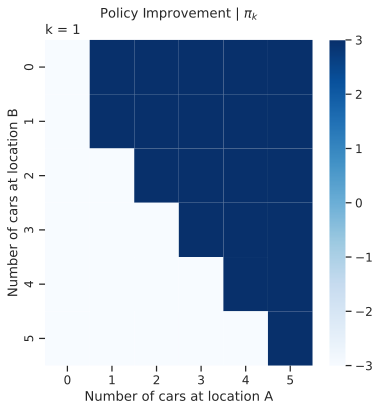

Completed Policy Improvement 1
Completed Policy Evaluation 1
Completed Policy Evaluation 2


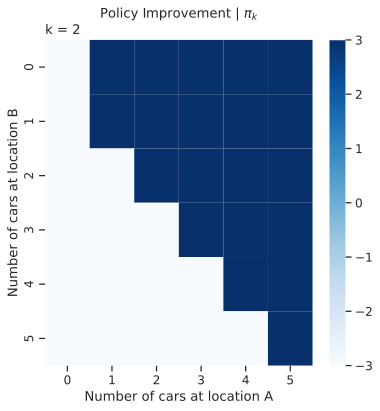

Completed Policy Improvement 2


In [ ]:
MAX_ITER_POLICY_EVALUATION = 5
MAX_ITER_POLICY_IMPROVEMENT = 5

states = [
    (cars_a, cars_b)
    for cars_a in range(0, MAX_CARS + 1)
    for cars_b in range(0, MAX_CARS + 1)
]

rewards = np.sort(
    np.unique(
        [
            (
                (rent_cars_a + rent_cars_b) * CAR_REWARD
                    - np.abs(move_cars) * -CAR_MOVE_COST
            )
            for rent_cars_a in range(MAX_CARS + 1)
            for rent_cars_b in range(MAX_CARS + 1)
            for move_cars in ACTIONS
        ],
    )
)


# Step 1. Initialization
values = np.zeros(shape=(MAX_CARS + 1, MAX_CARS + 1), dtype=int)
policies = np.zeros(shape=(MAX_CARS + 1, MAX_CARS + 1), dtype=int)

policy_improvement_iters = 0
policy_stable = False
while not policy_stable and policy_improvement_iters < MAX_ITER_POLICY_IMPROVEMENT:
    policy_improvement_iters += 1

    delta = np.inf
    policy_evaluation_iters = 0
    # Step 2. Policy Evaluation
    while delta > THETA and policy_evaluation_iters < MAX_ITER_POLICY_EVALUATION:
        policy_evaluation_iters += 1
        delta = 0
        for state in states:
            state_value = values[state]
            action = policies[state]
            values[state] = np.sum(
                [
                    prob_state_reward_given_state_action(
                        state_prime=state_prime,
                        reward=reward,
                        state=state,
                        action=action,
                    ) * (reward + GAMMA * values[state_prime])
                    for state_prime in states
                    for reward in rewards
                ]
            )
            delta = max(delta, np.abs(state_value - values[state]))
        
        # _, ax = plt.subplots()
        # sns.heatmap(values, cbar=True, cmap='Blues', ax=ax)
        # ax.set_title(f'k = {policy_evaluation_iters}', loc='left')
        # ax.set_title(r'Policy evaluation | $v_{\pi}k$', y=1.05)
        # ax.set_xlabel('Number of cars at location A')
        # ax.set_ylabel('Number of cars at location B')
        # plt.show()
        
        logging.info(f"Completed Policy Evaluation {policy_evaluation_iters}")

        if delta < THETA:
            break

    # Step 3. Policy Improvement
    policy_stable = True
    for state in states:
        old_action = policies[state]
        policies[state] = np.argmax(
            [
                np.sum(
                    [
                        prob_state_reward_given_state_action(
                            state_prime=state_prime,
                            reward=reward,
                            state=state,
                            action=action,
                        ) * (reward + GAMMA * values[state_prime])
                        for reward in rewards
                        for state_prime in states
                    ]
                )
                for action in ACTIONS
            ]
        ) - MAX_MOVING_CARS

        if old_action != policies[state]:
            policy_stable = False

    _, ax = plt.subplots()
    sns.heatmap(policies, cbar=True, cmap='Blues', ax=ax)
    ax.set_title(f'k = {policy_improvement_iters}', loc='left')
    ax.set_title(r'Policy Improvement | $\pi_k$', y=1.05)
    ax.set_xlabel('Number of cars at location A')
    ax.set_ylabel('Number of cars at location B')
    plt.show()

    logging.info(f"Completed Policy Improvement {policy_improvement_iters}")

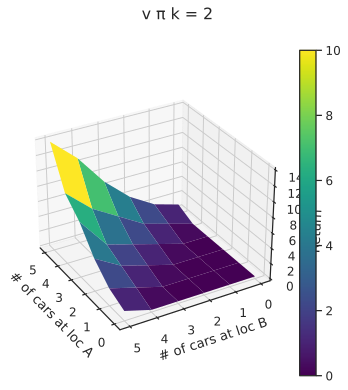

In [ ]:
x = np.arange(MAX_CARS+1)
y = np.arange(MAX_CARS+1)
X, Y = np.meshgrid(x, y)

fig = plt.figure()
fig.suptitle(f'v π k = {policy_evaluation_iters}',)
ax = plt.axes(projection='3d')
im = ax.plot_surface(X, Y, values, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_zlabel('Return')
ax.set_xlabel('# of cars at loc A')
ax.set_ylabel('# of cars at loc B')
ax.view_init(30, 150)
plt.colorbar(im);

### 4.4 Value Iteration: Gambler's Problem

Value iteration combines policy improvement with a truncated number of policy evaluation steps. This algorithm is thus faster.

\begin{align}
    v_{k+1} \equiv \underset{a}{\text{max}} \mathbb{E} \left[ R_{t+1} + \gamma v_k(S_{t+1}) \mid S_t = s, A_t=a  \right] \\
    = \underset{a}{\text{max}} \sum_{s', r} p(s', r \mid s, a) [r + \gamma v_{k}(s')]
\end{align}

for all $s \in \mathcal{S}$.

---

> **Excercise 4.9** Implement value iteration for the gambler's problem and solve it for $p_{h}=0.25$ and $p_h=0.55$. In programming, you may find it convenient to introduce two dummy states corresponding to termination with capital of 0 and 100, giving them values of 0 and 1 respectively. Show your results graphically, as in Figure 4.3. Are your results stable as $\theta \rightarrow 0$?

---

- The state-value function gives the probability of winning from each state
- A policy is a mapping from levels of capital (states) to stakes (actions)
- The optimal policy maximizes the probability of reaching the goal
    - Let $p_h$ denote the probability of the coin coming up heads. 



In [ ]:
# Initialize
PROB_HEADS = 0.25
GOAL = 100
THETA = 1e-2
posib_states = np.arange(0, 100, 1)
posib_rewards = np.array([0, 1])

values = np.zeros_like(posib_states)

In [ ]:
for state in posib_states:

    delta = 0

    # Update set of possible actions to choose from
    actions_set = np.arange(1, min(state, 100-state), 1) 
    state_value = 0
    for action in actions_set:
        action_value = []

        print(f'State: {state} | action: {action}')

        for state_prime in posib_states:
            for reward in posib_rewards:
                action_value.append(
                    PROB_HEADS    
                ) 


    
    state_value += max_action_value
        
        
    #next_state, reward, gambler_wins, terminate = step(state, action, gambler_wins)


    if state == 20:
        break
    

[]
[]
[1]
State: 2 | action: 1
[1 2]
State: 3 | action: 1
State: 3 | action: 2
[1 2 3]
State: 4 | action: 1
State: 4 | action: 2
State: 4 | action: 3
[1 2 3 4]
State: 5 | action: 1
State: 5 | action: 2
State: 5 | action: 3
State: 5 | action: 4
[1 2 3 4 5]
State: 6 | action: 1
State: 6 | action: 2
State: 6 | action: 3
State: 6 | action: 4
State: 6 | action: 5
[1 2 3 4 5 6]
State: 7 | action: 1
State: 7 | action: 2
State: 7 | action: 3
State: 7 | action: 4
State: 7 | action: 5
State: 7 | action: 6
[1 2 3 4 5 6 7]
State: 8 | action: 1
State: 8 | action: 2
State: 8 | action: 3
State: 8 | action: 4
State: 8 | action: 5
State: 8 | action: 6
State: 8 | action: 7
[1 2 3 4 5 6 7 8]
State: 9 | action: 1
State: 9 | action: 2
State: 9 | action: 3
State: 9 | action: 4
State: 9 | action: 5
State: 9 | action: 6
State: 9 | action: 7
State: 9 | action: 8
[1 2 3 4 5 6 7 8 9]
State: 10 | action: 1
State: 10 | action: 2
State: 10 | action: 3
State: 10 | action: 4
State: 10 | action: 5
State: 10 | action: 

UnboundLocalError: ignored

In [ ]:
def step(state: int, action: int, gambler_wins: int) -> Tuple[int, int, int, bool]:

    terminate = False

    # Flip a coin
    coin_outcome = np.random.binomial(n=1, p=PROB_HEADS)

    if coin_outcome == 0: # If heads
        # The gambler wins as many dollars as he has staked
        gambler_wins += action 

    # Update capital with money that was put to stake
    next_state = state - action

    if gambler_wins >= GOAL:
        reward += 1
        terminate = True
    if next_state <= 0:
        reward = 0
        terminate = True
    else:
        reward = 0

    return next_state, reward, gambler_wins, terminate